In [1]:
import pandas as pd
import pickle
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic as ct

import spacy
nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


In [2]:
# # Import the different sheets.

# yrs = ["2019", "2020"]
# df = pd.DataFrame()

# for sheet in yrs:
#     temp_df = pd.read_excel("../data/2019 - 2020 JCRP Metrics -EB.xlsx", 
#                    sheet_name = sheet)
#     df = pd.concat([df, temp_df])
    
# df = df.dropna(axis=0, how="all")

# # A lot of the Title entries are "Selected Abstracts..." and are from "Literature Update" article types.
# # However, the Vol 40 doesn't have article type so have to look through titles.

# df = df[df["Title"].str.contains("Selected Abstracts From Recent Publications") == False]

In [3]:
with open("../data/dataframe_with_abstracts.pickle", "rb") as read_file:
    df = pickle.load(read_file)

### Tokenize the text.

In [4]:
# Use spaCy to tokenize the text.

docs = list(nlp.pipe(df.Title))
df['spacy_doc'] = docs

In [5]:
# Text preprocessing. Removing stop words, puncuation, numbers, and user mentions (i.e., @xx).
# (also remove text used in the search of Twitter (i.e., "new", "years", "resolution")).

docs_clean = [[w.text.lower() for w in doc if \
               (not w.is_stop and not w.is_punct and not w.like_num and\
                w.text.lower() != "\xa0")] for doc in docs]
df['docs_clean'] = docs_clean

In [6]:
df["Text_clean"] = df["docs_clean"].map(lambda x: " ".join(x))

In [7]:
# Merge tokens together.
docs_list_clean = [' '.join(doc) for doc in df['docs_clean']]
docs_list_clean[:3]

['concordant evidence based interventions cardiac pulmonary rehabilitation guidelines',
 'pilot study self care breath training exercise reduction chronic dyspnea',
 'active video games training tool individuals chronic respiratory diseases   systematic review']

### Exploring possible topics.

In [9]:
# Function to display the top words associated with the topics.

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def topics_explore(vectorizer, num_topics, doc_lst, redux_model="NMF"):
    
    if redux_model == "NMF" or redux_model == "LSA":
        X = vectorizer.fit_transform(doc_lst)

        if redux_model == "LSA":
            topics = TruncatedSVD(num_topics)
        else:
            topics = NMF(num_topics)

        doc_topic = topics.fit_transform(X)

        return display_topics(topics, vectorizer.get_feature_names(), 10)
    
    elif redux_model == "LDA":
        vectorizer.fit(doc_lst)
        doc_word = vectorizer.transform(doc_lst).transpose()
        corpus = matutils.Sparse2Corpus(doc_word)
        id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
        lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5)
        
        return lda.print_topics()
    
    else:
            return "Select either LSA, NMF, or LDA."

In [24]:
tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.01, 
                     max_df = 0.8,
                     ngram_range=(2,4))

topics_explore(tv, 3, docs_list_clean, "LSA")


Topic  0
cardiac rehabilitation, physical activity, factors associated, exercise training, based cardiac, based cardiac rehabilitation, narrative review, self reported, home based cardiac rehabilitation, home based cardiac

Topic  1
heart failure, systematic review, pulmonary rehabilitation, patients heart failure, patients heart, chronic obstructive pulmonary disease, chronic obstructive pulmonary, chronic obstructive, obstructive pulmonary, obstructive pulmonary disease

Topic  2
pulmonary rehabilitation, cardiac pulmonary rehabilitation, cardiac pulmonary, outpatient pulmonary rehabilitation, outpatient pulmonary, health care, home based, cardiopulmonary rehabilitation, pulmonary rehabilitation programs, rehabilitation programs


In [25]:
cv = CountVectorizer(stop_words='english', 
                     min_df = 0.002, 
                     max_df = 0.70,
                     ngram_range=(2,3))

topics_explore(cv, 3, docs_list_clean, "NMF")


Topic  0
cardiac rehabilitation, based cardiac, based cardiac rehabilitation, coronary artery, outpatient cardiac rehabilitation, outpatient cardiac, home based, home based cardiac, utilization outpatient cardiac, utilization outpatient

Topic  1
heart failure, patients heart failure, patients heart, oxygen uptake, peak oxygen, peak oxygen uptake, ejection fraction, preserved ejection, preserved ejection fraction, uptake recovery

Topic  2
chronic obstructive, chronic obstructive pulmonary, pulmonary disease, obstructive pulmonary disease, obstructive pulmonary, patients chronic obstructive, patients chronic, randomized controlled, exercise training, aerobic exercise


/Users/jamespeterman/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


### Word Clouds.

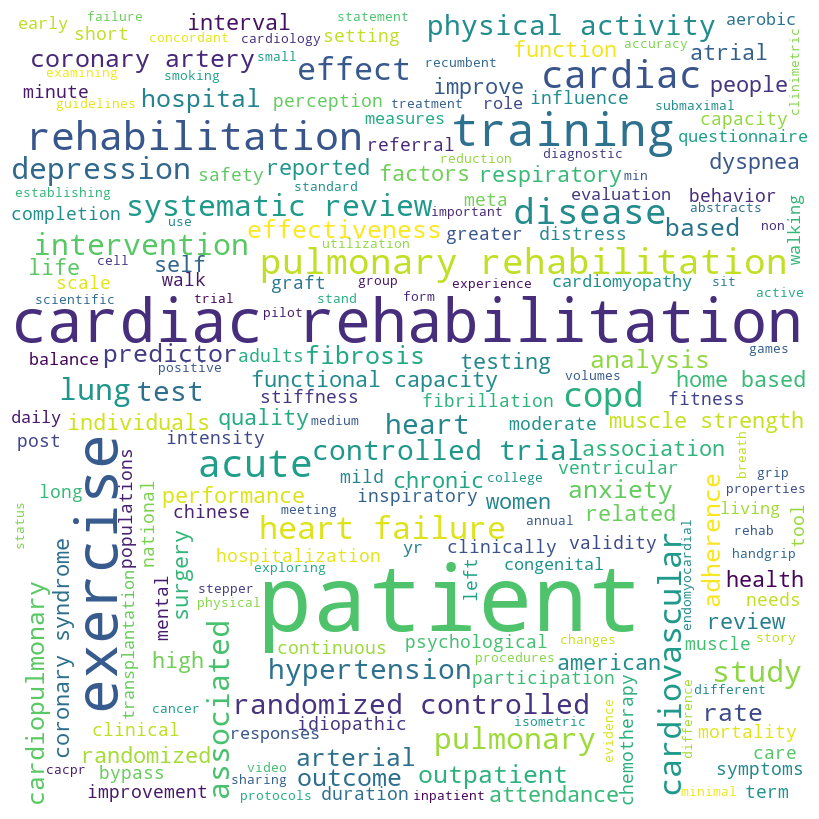

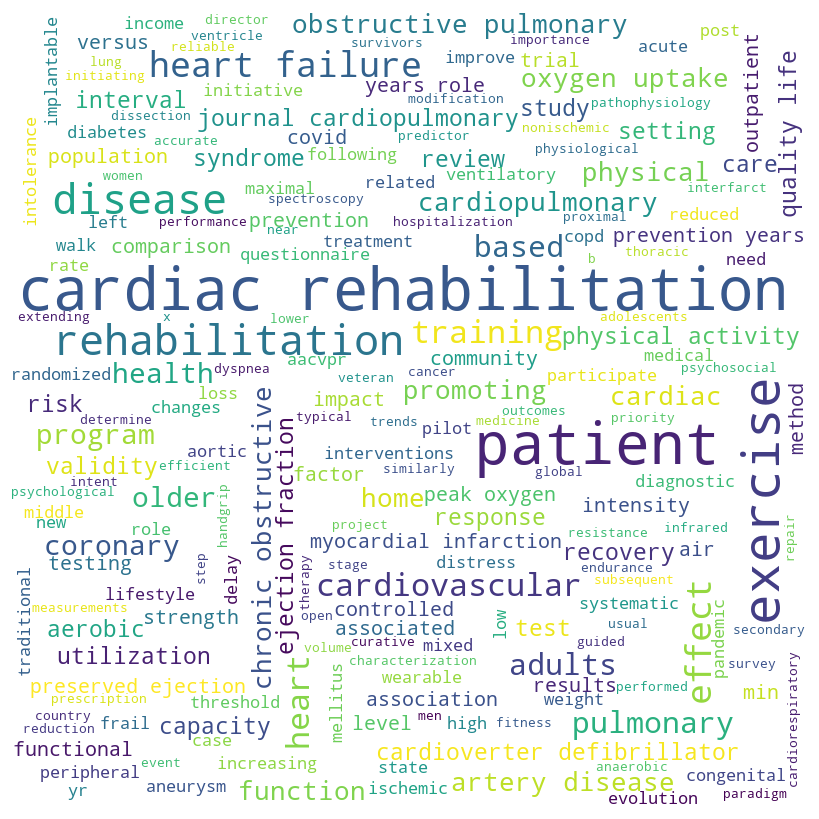

In [8]:
# Create a word cloud to illustrate the top words/phrases.

volumes = ["39", "40"]

for vol in volumes:
    
    df_text = df.query(f"Volume == {vol}")

    words = " ".join(df_text.Text_clean)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
#     plt.savefig(f"../images/wordcloud_vol{vol}")

In [12]:
# Create a rank according to Twitter popularity.

df["twitter_rank"] = df.Tweets.rank(pct=True)

df["Popularity"] = df.twitter_rank.map(lambda x: "Popular" if x>0.5 else "Less Popular")


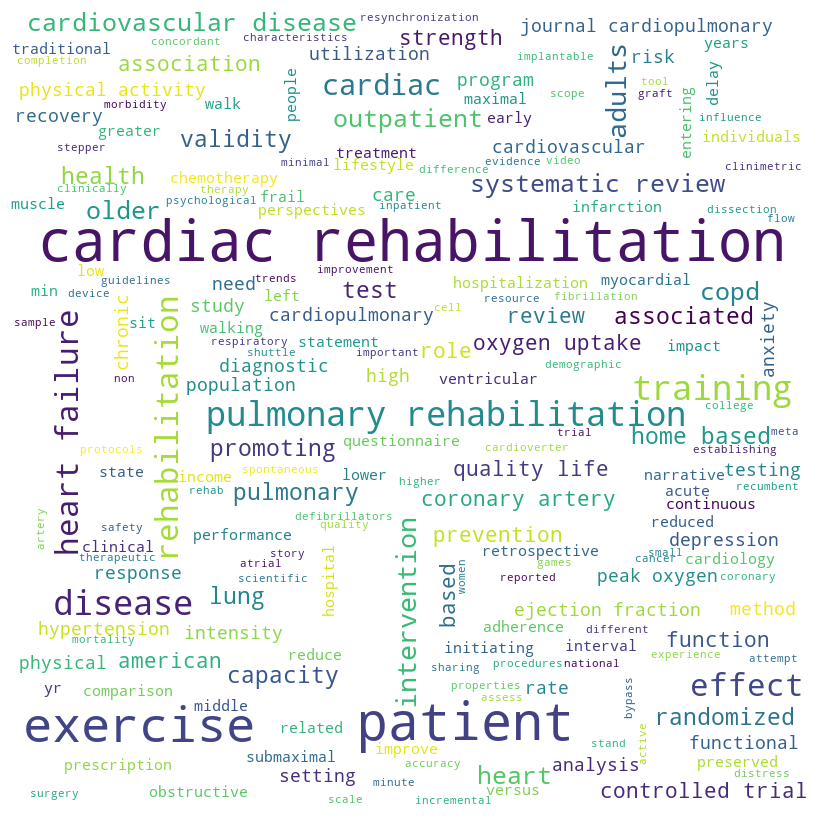

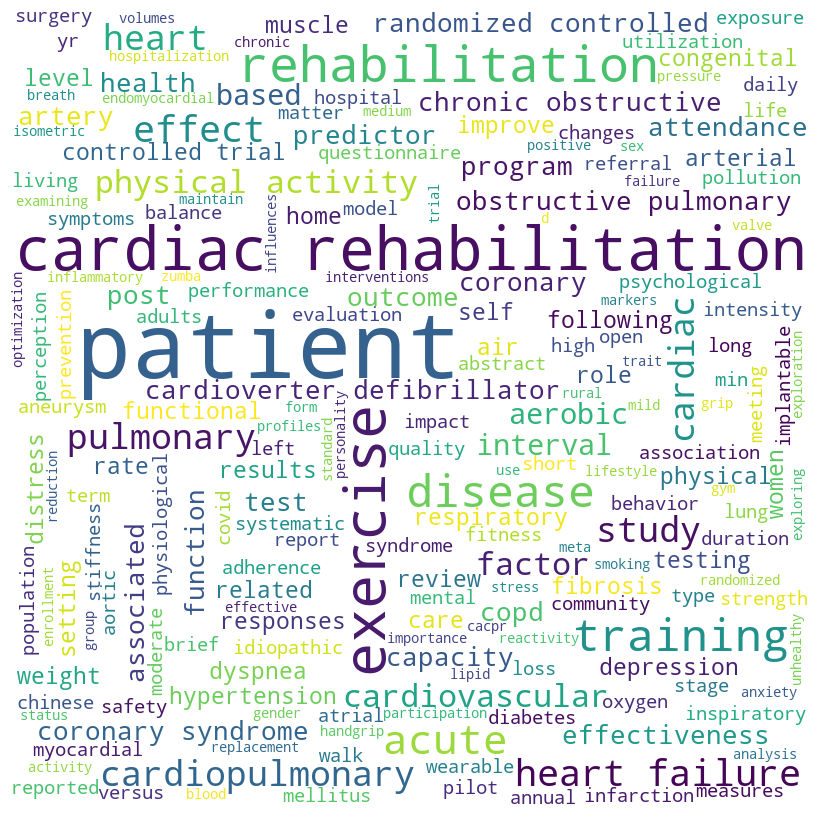

In [16]:
ranks = ["Popular", "Less Popular"]

for rank in ranks:
    
    df_text = df.query(f"Popularity == '{rank}'")

    words = " ".join(df_text.Text_clean)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()